In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np

root_dir = 'img_align_celeba'
img_size = (128, 128)

# Define the transformation. You might want to transform the images (e.g., resizing, normalization) for your specific task.
transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor(), # Convert images to tensor
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize images
])

dataset = ImageFolder(root_dir, transform=transform)
subset = Subset(dataset, range(100))

batch_size = 1
loader = DataLoader(subset, batch_size=batch_size, shuffle=False)

outside_weight = 0.4

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AutoEncoder(nn.Module):
    """Abstract AutoEncoder class"""
    encoder: nn.Module
    decoder: nn.Module
    
    def get_latent_size(self, img_size=img_size, n_channels=3):
        """Return the latent dimension of the AutoEncoder given an input image size."""
        
        dummy = torch.zeros((n_channels,) + img_size).unsqueeze(0).to(device)
        return self.encoder(dummy).squeeze(0).shape
    
    
class SaliencyAutoEncoder(nn.Module):
    def __init__(self):
        super(SaliencyAutoEncoder, self).__init__()
        
        self.saliency_mapper = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # 64x64
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, stride=2, padding=1), # 8x8 -> each pixel for each patch
        )
        
        self.high_res = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), # 16x16
            nn.ReLU(True),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), # 8x8
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()
        )
        
        self.low_res = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), # 16x16
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 8x8
            nn.ReLU(True),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), # 4x4
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()
        )
        
        self.image_size = 128
        self.patch_size = 16
        self.npatches_1d = 8
        self.channels = 3 # Channels of input image
        
        self.k = 32 # Half of total patches
        
    def fold(self, patches):
        # Parameters for patches
        batch_size, channels = patches.shape[0], patches.shape[1]
    
        # Reshape to satisfy fold inputs
        patches = patches.reshape((batch_size, channels, self.npatches_1d * self.npatches_1d, self.patch_size * self.patch_size))
        patches = patches.permute(0, 1, 3, 2).contiguous()
        patches = patches.view(batch_size, channels * self.patch_size * self.patch_size, self.npatches_1d * self.npatches_1d)

        # Calculate output size
        output_height = 8 * self.patch_size
        output_width = 8 * self.patch_size

        # Fold to reconstruct the image
        return F.fold(patches, output_size=(output_height, output_width), kernel_size=(self.patch_size, self.patch_size), stride=self.patch_size)

    
    def forward(self, x):
        saliency = self.saliency_mapper(x) # Nx1x8x8
        saliency = torch.flatten(saliency, start_dim=1, end_dim=-1) # Nx64
                
        topk = torch.topk(saliency, self.k, dim=-1)
        fg_mask = torch.zeros_like(saliency, dtype=torch.bool, device=device)
        fg_mask[torch.arange(fg_mask.size(0)).unsqueeze(1), topk.indices] = True
        fg_mask = fg_mask.reshape((fg_mask.size(0), 8, 8))
        bg_mask = ~fg_mask

        # Extract patches
        # [batch_size, channels, npatches_1d, npatches_1d, patch_size, patch_size]
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        # Bring npatches_1d dimensions forward
        patches = patches.permute((0, 2, 3, 1, 4, 5))
                
        fg = patches[fg_mask, ...] # [batch_size, k, C, P, P]
        bg = patches[bg_mask, ...] # [batch_size, 64 - k, C, P, P]
                
        r_fg = self.high_res(fg)
        r_bg = self.low_res(bg)
        
        r_patches = torch.zeros_like(patches, device=device)
        r_patches[fg_mask] = r_fg
        r_patches[bg_mask] = r_bg
        
        # Bring npatches_1d backwards to prep for fold
        r_patches = r_patches.permute((0, 3, 1, 2, 4, 5))
        
        return self.fold(r_patches)
            
    
class FCAutoEncoder(AutoEncoder):
    def __init__(self):
        super(FCAutoEncoder, self).__init__()
                
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(49152, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 49152),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 128, 128))
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class CNNAutoencoder(AutoEncoder):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
                
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # Input channels = 3 (RGB), Output channels = 16
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7) # No padding
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Using Sigmoid to ensure the output is between 0 and 1
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
# Test forward

model = SaliencyAutoEncoder().to(device)
model(torch.zeros((64, 3, 128, 128)).cuda())

tensor([[[[0.4604, 0.4683, 0.4698,  ..., 0.4682, 0.4695, 0.4687],
          [0.4612, 0.4664, 0.4710,  ..., 0.4663, 0.4712, 0.4652],
          [0.4580, 0.4658, 0.4658,  ..., 0.4657, 0.4655, 0.4664],
          ...,
          [0.4612, 0.4664, 0.4711,  ..., 0.4663, 0.4712, 0.4651],
          [0.4583, 0.4659, 0.4650,  ..., 0.4659, 0.4653, 0.4670],
          [0.4639, 0.4656, 0.4696,  ..., 0.4657, 0.4691, 0.4626]],

         [[0.5281, 0.5253, 0.5280,  ..., 0.5254, 0.5278, 0.5229],
          [0.5263, 0.5238, 0.5271,  ..., 0.5238, 0.5266, 0.5173],
          [0.5304, 0.5200, 0.5273,  ..., 0.5201, 0.5267, 0.5138],
          ...,
          [0.5264, 0.5239, 0.5270,  ..., 0.5239, 0.5264, 0.5172],
          [0.5297, 0.5219, 0.5264,  ..., 0.5218, 0.5261, 0.5144],
          [0.5245, 0.5221, 0.5229,  ..., 0.5220, 0.5237, 0.5161]],

         [[0.5431, 0.5331, 0.5333,  ..., 0.5331, 0.5330, 0.5293],
          [0.5449, 0.5357, 0.5362,  ..., 0.5358, 0.5363, 0.5297],
          [0.5483, 0.5366, 0.5388,  ..., 0

In [14]:
# Model instantiation
model = SaliencyAutoEncoder().to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
num_epochs = 100
total_data = len(subset)

In [15]:

import torch.nn.functional as F
# from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage
from facenet_pytorch import MTCNN

mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

def tensor_to_img(t):
    img_tensor = (t * 255).byte()
    to_pil_image = ToPILImage()
    img = to_pil_image(img_tensor)

    return img
    
def scale_outside_bbox(tensor, bbox, scale_factor):
    bbox = bbox.long()
    # Create masks for each box
    mask = torch.full_like(tensor, scale_factor)
    x_min, y_min, x_max, y_max = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    
    for i in range(tensor.shape[0]): # See if we can batch this later
        mask[i, y_min[i]:y_max[i], x_min[i]:x_max[i]] = 1

    tensor_masked = tensor * mask
    
    return tensor_masked


def inside_outside(tensor, bbox):
    bbox = bbox.long()
    # Create masks for each box
    mask = torch.full_like(tensor, 0)
    x_min, y_min, x_max, y_max = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]

    for i in range(tensor.shape[0]): # See if we can batch this later        
        mask[i, :, y_min[i]:y_max[i], x_min[i]:x_max[i]] = 1
                        
    return tensor * mask, tensor * (1 - mask)


def objective(source, reconstruction):
    boxes, _ = mtcnn.detect(source.permute(0, 2, 3, 1) * 255)

    bbox = torch.from_numpy(np.floor(boxes[:, 0, :]).astype(int))
        
    ins_s, out_s = inside_outside(source, bbox)
    ins_r, out_r = inside_outside(reconstruction, bbox)
            
    loss = F.mse_loss(ins_s, ins_r, reduction='sum')
    loss += F.mse_loss(out_s, out_r, reduction='sum') * outside_weight
    
    return loss

In [16]:
# Test objective
objective(dataset[0][0].unsqueeze(0), dataset[0][0].unsqueeze(0))

tensor(0.)

In [17]:
# Training loop
for epoch in range(num_epochs):
    for data in loader:
        img, _ = data
        img = img.to(device)
        
        # Forward pass
        outputs = model(img)

        # loss = criterion(outputs, img)
        loss = objective(img, outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if not i % 25:
        #     print(f'Batch {i}, Loss: {loss.item():.4f}')
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 10023.8086
Epoch [2/100], Loss: 9860.7578
Epoch [3/100], Loss: 9706.5928
Epoch [4/100], Loss: 9531.0137
Epoch [5/100], Loss: 9298.3887
Epoch [6/100], Loss: 8968.5625
Epoch [7/100], Loss: 8521.0020
Epoch [8/100], Loss: 8060.2432
Epoch [9/100], Loss: 7706.5630
Epoch [10/100], Loss: 7388.2979
Epoch [11/100], Loss: 7000.9912
Epoch [12/100], Loss: 6569.9531
Epoch [13/100], Loss: 6116.6201
Epoch [14/100], Loss: 5716.2944
Epoch [15/100], Loss: 5182.0396
Epoch [16/100], Loss: 4624.1323
Epoch [17/100], Loss: 4036.4172
Epoch [18/100], Loss: 3496.5815
Epoch [19/100], Loss: 3012.2485
Epoch [20/100], Loss: 2585.6270
Epoch [21/100], Loss: 2222.6677
Epoch [22/100], Loss: 1920.5509
Epoch [23/100], Loss: 1699.0944
Epoch [24/100], Loss: 1530.0483
Epoch [25/100], Loss: 1390.8130
Epoch [26/100], Loss: 1278.0940
Epoch [27/100], Loss: 1189.6523
Epoch [28/100], Loss: 1113.2384
Epoch [29/100], Loss: 1052.0275
Epoch [30/100], Loss: 1003.4475
Epoch [31/100], Loss: 963.2068
Epoch [32/100], L

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_pair(img):
    plt.figure(figsize=(10, 5)) 
    plt.subplot(121)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    
    reconstruction = model(img.to(device).unsqueeze(0)).squeeze(0).to('cpu').detach()
    plt.subplot(122)
    plt.imshow(torch.permute(reconstruction, (1, 2, 0)))

In [19]:
# torch.save(model, f'two-resolution, normal-l2.pt')

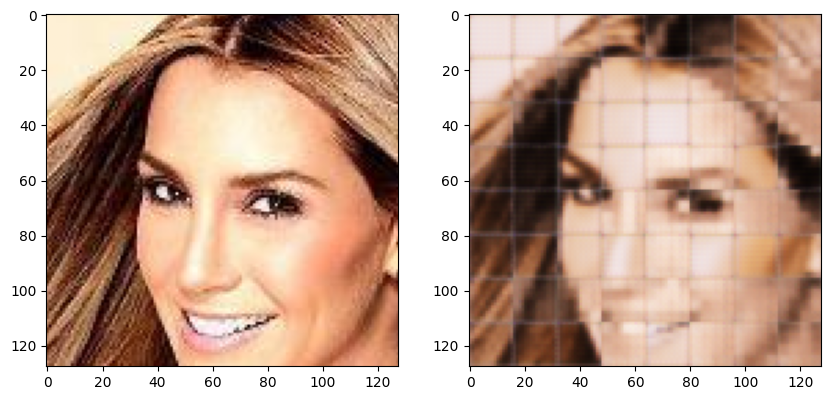

In [20]:
show_pair(dataset[0][0])